<a href="https://colab.research.google.com/github/danielzmbp/lspred/blob/main/ls-pred_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner


     |████████████████████████████████| 71kB 3.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=f8bf35528f66d43ef9afdd327c3eb902e94ea5081cba4f3005c546f58cd2cf1f
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=420a85daa38979598f4b7677e8f997fecca944faecac6b6a9420242cc57614e8
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


# LS- pred
In this notebook I develop a model to predict lifestyle based on InterProScan annotations. The input tsv files consist
of the table outputs from the [genome-properties](https://github.com/ebi-pf-team/genome-properties) script.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
import IPython
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Merge dfs

In [3]:
X = pd.read_csv("ls-pred.csv",header=None)

In [4]:
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5165,5166,5167,5168,5169,5170,5171,5172,5173,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183,5184,5185,5186,5187,5188,5189,5190,5191,5192,5193,5194,5195,5196,5197,5198,5199,5200,5201,5202,5203,5204
0,3,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,3,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
315,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
316,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
317,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [5]:
y = X.iloc[:,0]

In [6]:
X = X.iloc[:,1:]

In [7]:
y = np.array(y)

In [8]:
X = X.values

In [9]:
X.shape

(319, 5204)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

In [11]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

In [12]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(5204))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  model.add(keras.layers.Dense(units = hp.Int('u1', min_value = 32, max_value = 512, step = 32),
                               activation=hp.Choice(name='a_1',
                               values=['relu','elu','selu'])))
  model.add(keras.layers.Dense(units = hp.Int('u2', min_value = 32, max_value = 512, step = 32),
                               activation=hp.Choice(name='a_2',
                               values=['relu','elu','selu'])))
  model.add(keras.layers.Dense(4,activation='softmax'))

  # Tune the learning rate for the optimizer 
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-3,1e-4, 1e-5]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
  
  return model

In [13]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'tuner',
                     project_name = 'hyperband_test')                       

In [14]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [15]:
tuner.search(X_train, y_train, epochs = 50, 
             validation_data = (X_valid, y_valid), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 90 Complete [00h 01m 32s]
val_accuracy: 0.96875

Best val_accuracy So Far: 0.96875
Total elapsed time: 00h 38m 34s
INFO:tensorflow:Oracle triggered exit


In [16]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid))

Epoch 1/50
8/8 [==============================] - 3s 233ms/step - loss: 3.1473 - accuracy: 0.2952 - val_loss: 2.5307 - val_accuracy: 0.3750
Epoch 2/50
8/8 [==============================] - 2s 212ms/step - loss: 1.6774 - accuracy: 0.5377 - val_loss: 1.1080 - val_accuracy: 0.5000
Epoch 3/50
8/8 [==============================] - 2s 210ms/step - loss: 1.0698 - accuracy: 0.6235 - val_loss: 0.7684 - val_accuracy: 0.7500
Epoch 4/50
8/8 [==============================] - 2s 235ms/step - loss: 0.7186 - accuracy: 0.7221 - val_loss: 0.5951 - val_accuracy: 0.8750
Epoch 5/50
8/8 [==============================] - 2s 207ms/step - loss: 0.5353 - accuracy: 0.8446 - val_loss: 0.4668 - val_accuracy: 0.9062
Epoch 6/50
8/8 [==============================] - 2s 219ms/step - loss: 0.4322 - accuracy: 0.8758 - val_loss: 0.3708 - val_accuracy: 0.8750
Epoch 7/50
8/8 [==============================] - 2s 206ms/step - loss: 0.2762 - accuracy: 0.9282 - val_loss: 0.3929 - val_accuracy: 0.8125
Epoch 8/50
8/8 [====

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5204)              27086820  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               666240    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 27,787,112
Trainable params: 27,787,112
Non-trainable params: 0
_________________________________________________________________


In [19]:
results = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 75ms/step - loss: 0.0199 - accuracy: 1.0000


In [20]:
model.save("lspred_15_2_21.h5")

## Stats

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

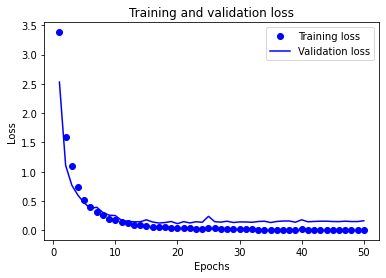

In [22]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

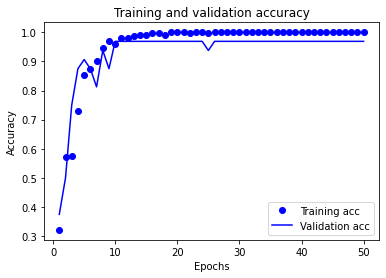

In [23]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
from sklearn.metrics import confusion_matrix


In [25]:
predictions = model.predict(
      x=X_test
    , batch_size=10
    , verbose=0
)  

In [26]:
rounded_predictions = np.argmax(predictions, axis=-1)


In [27]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)


In [28]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
cm_plot_labels = ['saprotroph','necrotroph','hemibiotroph','biotroph']


In [30]:
import itertools

Confusion matrix, without normalization
[[10  0  0  0]
 [ 0  9  0  0]
 [ 0  0  6  0]
 [ 0  0  0  7]]


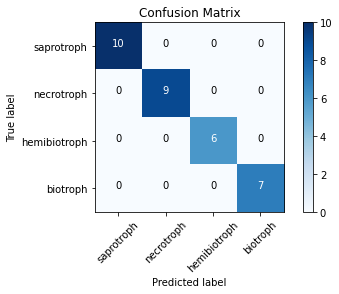

In [41]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig("confusion_matrix_15221.pdf",bbox_inches='tight',dpi=300)

In [32]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [33]:
y_test_b = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes= 4

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [35]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [36]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [37]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

In [38]:
mean_tpr /= n_classes

In [39]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

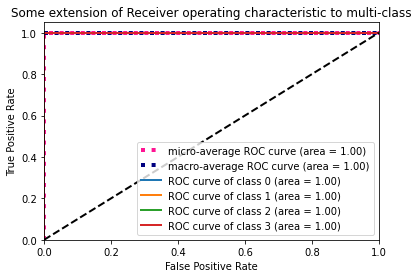

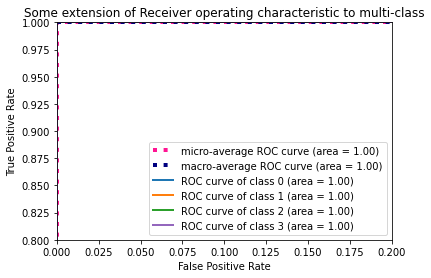

In [40]:
lw=2
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['C0','C1','C2','C3'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['C0', 'C1', 'C2', 'C4'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()